### Basic Chatbot with Langgraph (GraphAPI)

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [2]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function"
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages:Annotated[list, add_messages]

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(model="llama3-8b-8192")
llm=init_chat_model("groq:llama3-8b-8192")

In [5]:
#Node Functionality
def chatbot(state:State):
  return {"messages":[llm.invoke(state["messages"])]}

In [6]:
graph_builder = StateGraph(State)
#add node
graph_builder.add_node("llm_chatbot",chatbot)

#add edges
graph_builder.add_edge(START,"llm_chatbot")
graph_builder.add_edge("llm_chatbot",END)

#compile graph
graph = graph_builder.compile()


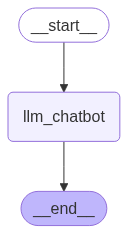

In [7]:
#Visualize the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [8]:
response = graph.invoke({"messages":["Hi"]})

In [9]:
response['messages'][-1].content

"Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [10]:
#responses from llm chatbot 
for event in graph.stream({"messages":["Hello, how are you?"]}):
    for value in event.values():
        print(value["messages"][-1].content)

I'm just a language model, I don't have emotions or feelings, but I'm here to help you with any questions or concerns you may have! How can I assist you today?


### Chatbot with Tavily

In [11]:
from langchain_tavily import TavilySearch

search_tool = TavilySearch(max_results=2)
search_tool.invoke("What is the capital of France?")

{'query': 'What is the capital of France?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'What is the Capital of France? - WorldAtlas',
   'url': 'https://www.worldatlas.com/articles/what-is-the-capital-of-france.html',
   'content': 'Paris is the capital city of France. Contrary to popular belief, the name of the city did not come from the Paris in Greek myths. Located in the north of Central France, the city is relatively flat with the highest point being 427 feet (which is Montmartre) above sea level while the lowest point is 115 feet above the sea level. With a GDP of approximately $850 billion, Paris is the country’s leader for economic activities. Tourists are attracted to Paris because of the rich history the city has including its monuments and sights. As the capital city of France, the city plays host to the national government of France. How Many Countries Are There In Africa? [x] Countries  All Countries',
   'score': 0.9170729,
   'ra

In [12]:
## Custom function
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

In [13]:
tools=[search_tool, multiply]

In [14]:
llm_with_tool = llm.bind_tools(tools)

In [15]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x10c4a9580>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x10c4a9b80>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list of domains to 

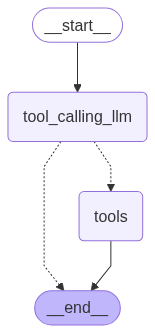

In [16]:
#State Graph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode 
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display

#Node definition
def tool_calling_llm(state:State):
    return {"messages":llm_with_tool.invoke(state["messages"])}


#Graph definition

builder = StateGraph(State)

builder.add_node("tool_calling_llm",tool_calling_llm)

builder.add_node("tools",ToolNode(tools))

#add edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition)

builder.add_edge("tools", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [17]:
# response = graph.invoke({"messages":"What is latest ai news?"})

In [18]:
# response['messages'][-1].content

In [19]:
# for m in response["messages"]:
#     m.pretty_print()

In [20]:
# response=graph.invoke({"messages":"What is 5 multiplied by 2"})
# for m in response['messages']:
#     m.pretty_print()

In [21]:
# response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
# for m in response['messages']:
#     m.pretty_print()

### ReAct Agent Architecture

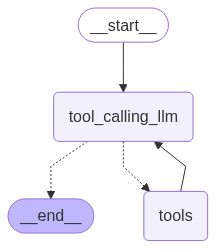

In [22]:
#State Graph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode 
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display

#Node definition
def tool_calling_llm(state:State):
    return {"messages":llm_with_tool.invoke(state["messages"])}


#Graph definition

builder = StateGraph(State)

builder.add_node("tool_calling_llm",tool_calling_llm)

builder.add_node("tools",ToolNode(tools))

#add edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition)

builder.add_edge("tools", "tool_calling_llm")

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
# response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
# for m in response['messages']:
#     m.pretty_print()

### Adding Memory in Agentic Graph

In [24]:
# response = graph.invoke({"messages":"Hello my name is Vinay"})
# for m in response["messages"]:
#     m.pretty_print()

In [25]:
# response = graph.invoke({"messages":"what is my name?"})
# for m in response["messages"]:
#     m.pretty_print()

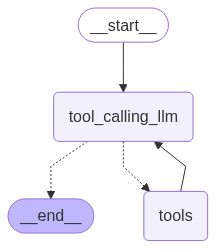

In [26]:
#State Graph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode 
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

#Node definition
def tool_calling_llm(state:State):
    return {"messages":llm_with_tool.invoke(state["messages"])}


#Graph definition

builder = StateGraph(State)

builder.add_node("tool_calling_llm",tool_calling_llm)

builder.add_node("tools",ToolNode(tools))

#add edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition)

builder.add_edge("tools", "tool_calling_llm")

graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
# config={"configurable":{"thread_id":"1"}}
# response = graph.invoke({"messages":"Hi my name is Vinay"}, config=config)
# response

In [28]:
# response = graph.invoke({"messages":"what is my name?"}, config=config)
# print(response['messages'][-1].content)

In [29]:
# response=graph.invoke({"messages":"Hey do you remember mmy name"},config=config)

# print(response['messages'][-1].content)

### Streaming

In [30]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [31]:
def superbot(state:State):
  return {"messages":[llm.invoke(state["messages"])]}

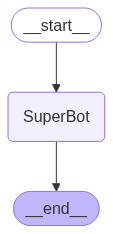

In [32]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode 
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display

graph=StateGraph(State)

## node
graph.add_node("SuperBot",superbot)
## Edges

graph.add_edge(START,"SuperBot")
graph.add_edge("SuperBot",END)


graph_builder=graph.compile(checkpointer=memory)


## Display
from IPython.display import Image, display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [33]:
## Invocation

config = {"configurable": {"thread_id": "1"}}

graph_builder.invoke({"messages":"Hi,My name is Vinay And I like cricket"},config)

{'messages': [HumanMessage(content='Hi,My name is Vinay And I like cricket', additional_kwargs={}, response_metadata={}, id='f5506f2d-1135-4b01-8e42-11d7748ffe4b'),
  AIMessage(content="Nice to meet you, Vinay! Cricket is a great sport, isn't it? Which team do you support? Do you have a favorite player or a favorite match that you always remember?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 21, 'total_tokens': 61, 'completion_time': 0.040239178, 'prompt_time': 0.004405165, 'queue_time': 0.0018889930000000003, 'total_time': 0.044644343}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8af39bf2ae', 'finish_reason': 'stop', 'logprobs': None}, id='run--b2520ba9-6d02-4112-85f0-49f4ff025a52-0', usage_metadata={'input_tokens': 21, 'output_tokens': 40, 'total_tokens': 61})]}

### Streaming 
Methods: .stream() and astream()

- These methods are sync and async methods for streaming back results.

Additional parameters in streaming modes for graph state

- **values** : This streams the full state of the graph after each node is called.
- **updates** : This streams updates to the state of the graph after each node is called.

In [34]:
# Create a thread
config = {"configurable": {"thread_id": "3"}}

for chunk in graph_builder.stream({"messages":"Hi,My name is Vinay And I like cricket"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Hi Vinay! Nice to meet you! Cricket is a great sport, isn't it? Who's your favorite cricketer or team?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 21, 'total_tokens': 51, 'completion_time': 0.029645897, 'prompt_time': 0.003572875, 'queue_time': 0.0018131819999999996, 'total_time': 0.033218772}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--ac38c80d-9d76-4575-94d0-80fbbc5ed773-0', usage_metadata={'input_tokens': 21, 'output_tokens': 30, 'total_tokens': 51})]}}


In [35]:
for chunk in graph_builder.stream({"messages":"Hi,My name is Vinay And I like cricket"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Vinay And I like cricket', additional_kwargs={}, response_metadata={}, id='58e3b5c4-e7c2-4b26-b48d-d324ff9f40cc'), AIMessage(content="Hi Vinay! Nice to meet you! Cricket is a great sport, isn't it? Who's your favorite cricketer or team?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 21, 'total_tokens': 51, 'completion_time': 0.029645897, 'prompt_time': 0.003572875, 'queue_time': 0.0018131819999999996, 'total_time': 0.033218772}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--ac38c80d-9d76-4575-94d0-80fbbc5ed773-0', usage_metadata={'input_tokens': 21, 'output_tokens': 30, 'total_tokens': 51}), HumanMessage(content='Hi,My name is Vinay And I like cricket', additional_kwargs={}, response_metadata={}, id='450a9317-fa0b-4192-ad4e-fd62b09338be')]}
{'messages': [HumanMessage(content='Hi,My name is Vinay And I like 

In [37]:
config = {"configurable": {"thread_id": "4"}}

async for chunk in graph_builder.astream_events({"messages":"Hi,My name is Vinay And I like cricket"},config,version="v2"):
    print(chunk)

{'event': 'on_chain_start', 'data': {'input': {'messages': 'Hi,My name is Vinay And I like cricket'}}, 'name': 'LangGraph', 'tags': [], 'run_id': '3c1f2fe9-95cd-4fd7-8534-a6e1c4e95d8a', 'metadata': {'thread_id': '4'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi,My name is Vinay And I like cricket', additional_kwargs={}, response_metadata={}, id='6e495cb1-dcd0-472f-9441-947b5e0f5ea7')]}}, 'name': 'SuperBot', 'tags': ['graph:step:1'], 'run_id': 'ff272ba1-3aa2-4b62-a482-7e9378a69d07', 'metadata': {'thread_id': '4', 'langgraph_step': 1, 'langgraph_node': 'SuperBot', 'langgraph_triggers': ('branch:to:SuperBot',), 'langgraph_path': ('__pregel_pull', 'SuperBot'), 'langgraph_checkpoint_ns': 'SuperBot:950abfac-6347-d449-68fe-11344404de01'}, 'parent_ids': ['3c1f2fe9-95cd-4fd7-8534-a6e1c4e95d8a']}
{'event': 'on_chain_stream', 'run_id': 'ff272ba1-3aa2-4b62-a482-7e9378a69d07', 'name': 'SuperBot', 'tags': ['graph:step:1'], 'metadata': {'thre

### Human Feedback in the loop

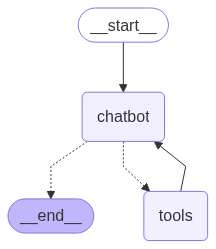

In [43]:
from langgraph.types import Command, interrupt
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver


graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Request assistance form a human"""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tool = llm.bind_tools(tools)

def chatbot(state:State):
    message = llm_with_tool.invoke(state["messages"])
    return {"messages":[message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges("chatbot", tools_condition)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")


memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

## Display
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [44]:
user_input = "I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": user_input},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (52zx0zsw5)
 Call ID: 52zx0zsw5
  Args:
    query: Expert guidance and assistance for building an AI agent


In [45]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response}) 

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (52zx0zsw5)
 Call ID: 52zx0zsw5
  Args:
    query: Expert guidance and assistance for building an AI agent
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

Thank you for the response. I will consider LangGraph as a viable option for building my AI agent. However, I would like to gather more information before making a decision. Could you please provide some more details about LangGraph, such as its architecture, scalability, and any notable features or functionalities it offers? 

Additionally, are there any other tools or options you would recommend for building an AI agent? 

P